# 데이터세트 구축

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import sklearn.model_selection as ms
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score ## F1 Score 구하기
from sklearn.metrics import precision_recall_fscore_support as sk
import pandas as pd 
import os

In [4]:
os.chdir("..")
path=os.getcwd()
plt.rcParams['font.family'] = 'Times New Roman'

In [5]:
path

'c:\\jupyter\\Explainable Healthcare framework\\Explainable_healthcareframework'

In [6]:
seoul_data=pd.read_csv(path+"\\data\\5.서울초_df_final.csv",encoding="cp949")

## ID 라벨 인코딩

In [7]:
from Datapreprocessing.id_labelencoding import LabelEncoderWrapper 

df_encoder = LabelEncoderWrapper(seoul_data, 'ID')
df_encoder.fit()
df_encoder.transform()

## m day n term

일별 데이터를 다루기 때문에 처음에 접근한 방법으로는 몸무게의 변동이 거의 없을 수 밖에 없었다.   
그래서 14일치 묶음으로 1일 윈도우로 이동하면서 몸무게 변동의 유의미한 차이를 만들기 위한 데이터세트를 구축하였다.  
따라서 한 로우에 14일치 평균 그리고 다음 로우는 그 다음날부터 14일치 평균값이다. 

In [8]:
from Datapreprocessing.M_day_N_term import RollingAveragesCalculator
M_day=14
n_term=1
columns_to_average = ["ID",'height', 'weight', 'step count', 'burned calorie', 'eat calorie', 'sleep time']
calculator = RollingAveragesCalculator(seoul_data)
result_df = calculator.calculate_averages(columns_to_average, M_day, n_term)

In [9]:
name='{}day_{}term'.format(M_day,n_term)
print(name)

14day_1term


## 라벨링

라벨링은 임계값 몸무게 변동 차이 100g을 기준으로 이전 평균 몸무게 보다 증가하면 3, 유지면 2, 감소면 1로 라벨링하였다.    

In [10]:
from Datapreprocessing.labeling import WeightChangeLabeler

Threshhold=0.1 # 몸무게가 얼마나 차이나야 변했다고 정할 것 인지 정하는 임계값
labeler = WeightChangeLabeler(result_df, Threshhold)
labeled_df = labeler.label_weight_changes()
print(labeled_df)

        ID      height     weight    step count  burned calorie  eat calorie  \
0        0  136.246429  28.478571   2051.107143       41.604375  2324.526395   
1        0  136.295238  28.571429   2113.707143       41.604375  2329.058538   
2        0  136.344048  28.664286   2205.121429       41.604375  2339.296038   
3        0  136.392857  28.757143   2325.350000       41.604375  2343.763895   
4        0  136.441667  28.850000   2474.392857       41.604375  2342.462110   
...    ...         ...        ...           ...             ...          ...   
40893  241  156.900000  47.500000  20000.000000       33.915000  1056.000000   
40894  241  156.900000  47.500000  20000.000000       33.915000  1056.000000   
40895  241  156.900000  47.500000  20000.000000       33.915000  1056.000000   
40896  241  156.900000  47.500000  20000.000000       33.915000  1056.000000   
40897  241  156.900000  47.500000  20000.000000       33.915000  1056.000000   

       sleep time  Start_Day Label  
0 

In [11]:
labeled_df['Label']=labeled_df['Label'].astype(int)

In [12]:
labeled_df['Label'].value_counts()

Label
2    39059
3     1300
1      539
Name: count, dtype: int64

###  데이터 세트 로드

In [13]:
data=labeled_df.iloc[:,[1,2,3,4,5,6,-1]]
train=data.iloc[:,:-1]
train_targets=data.iloc[:,-1]

### 데이터 세트 셋업

In [14]:
X_test=train.to_numpy()
y_test=train_targets-1

In [15]:
test_np = X_test

test_targets_np=y_test.astype(int)

### 생성 method 리스트

In [16]:
Generation= 'nbsynthetic'

## 모델 불러오기

### 제안한 모델

In [17]:
import os

In [18]:
notebook_path = os.path.abspath('.')
print("노트북 경로:", notebook_path)

노트북 경로: c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework


In [19]:
# # 먼저 nbimport 설치 (처음 한번만)
# !pip install nbimport

In [20]:
import nbimport
from encoding_tabnet import train_tabnet_classifier,  create_augmented_features

In [21]:
import pandas as pd
import pickle
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support as sk
from encoding_tabnet import train_tabnet_classifier,create_augmented_features
import os

# 현재 디렉토리 및 프로젝트 루트 디렉토리 경로 설정
# current_dir = os.path.dirname(os.path.abspath(__file__))
# path = os.path.dirname(current_dir)

def evaluate_generalization():
    """모델의 일반화 성능을 외부 데이터셋으로 평가하는 함수"""
    # 빈 리스트 생성하여 결과 저장
    results = []
    
    # nbsynthetic만 평가
    generation = 'nbsynthetic'
    
    # 외부 테스트 데이터 로드
    print(f"외부 테스트 데이터 크기: {test_np.shape}, 타겟 크기: {test_targets_np.shape}")
    print(f"타겟 클래스 분포: {np.unique(test_targets_np, return_counts=True)}")
    
    print(f"\n{generation} 모델로 외부 데이터 평가 중...")
    
    try:
        # TabNet 모델 로드
        tabnet_path = path + f'\\3_1.Training_XAI_Proposed\\model_hist\\{generation}_proposed_tabnetEmbedd2.pickle'
        with open(tabnet_path, 'rb') as f:
            tabnet_model = pickle.load(f)
        print(f"TabNet 모델 로드 성공: {tabnet_path}")
        
        # XGBoost 모델 로드
        xgb_path = path + f'\\3_1.Training_XAI_Proposed\\model_hist\\{generation}_proposed.pickle'
        with open(xgb_path, 'rb') as f:
            xgb_model = pickle.load(f)
        print(f"XGBoost 모델 로드 성공: {xgb_path}")
        
        # TabNet 임베딩 추출 및 특성 증강
        test_features = create_augmented_features(tabnet_model, test_np)
        print(f"TabNet 특성 증강 완료: {test_features.shape}")
        
        # TabNet으로 확률 예측
        tabnet_probs = tabnet_model.predict_proba(test_np)
        
        # XGBoost로 확률 예측
        xgb_probs = xgb_model.predict_proba(test_features)

        # 확률 합산 (앙상블)
        combined_probs = (tabnet_probs + xgb_probs)
        
        # 가장 높은 확률을 가진 클래스 선택
        ensemble_pred = np.argmax(combined_probs, axis=1)

        # 예측값 확인
        unique_values = np.array(list(set(ensemble_pred)))
        print(f"Unique values in prediction: {unique_values}")
        
        # 메트릭 계산
        accuracy = accuracy_score(test_targets_np, ensemble_pred)
        f1 = f1_score(test_targets_np, ensemble_pred, average='weighted')
        precision, recall = sk(test_targets_np, ensemble_pred, beta=1, average='weighted')[:2]
        
        results.append({
            'Model': f"{generation}-proposed_external",
            'Accuracy': round(accuracy, 5),
            'F1score': round(f1, 5), 
            'Precision': round(precision, 5),
            'Recall': round(recall, 5)
        })
        
    except Exception as e:
        print(f"{generation} 모델 평가 중 오류 발생: {str(e)}")
    
    # 결과를 데이터프레임으로 변환
    df_results = pd.DataFrame(results)
    print("\n외부 데이터셋에 대한 모델 성능 요약:")
    print(df_results)
    
    # 결과 저장
    output_path = path + '\\3_1.Training_XAI_Proposed\\external_test_results.csv'
    df_results.to_csv(output_path, index=False)
    print(f"결과가 {output_path}에 저장되었습니다.")
    
    return df_results,ensemble_pred,tabnet_model

if __name__ == "__main__":
    df_results,ensemble_pred,tabnet_model=evaluate_generalization()

외부 테스트 데이터 크기: (40898, 6), 타겟 크기: (40898,)
타겟 클래스 분포: (array([0, 1, 2]), array([  539, 39059,  1300], dtype=int64))

nbsynthetic 모델로 외부 데이터 평가 중...
TabNet 모델 로드 성공: c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\model_hist\nbsynthetic_proposed_tabnetEmbedd2.pickle
XGBoost 모델 로드 성공: c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\model_hist\nbsynthetic_proposed.pickle
TabNet 특성 증강 완료: (40898, 6)
Unique values in prediction: [0 1 2]

외부 데이터셋에 대한 모델 성능 요약:
                           Model  Accuracy  F1score  Precision   Recall
0  nbsynthetic-proposed_external   0.95572  0.93912    0.93838  0.95572
결과가 c:\jupyter\Explainable Healthcare framework\Explainable_healthcareframework\3_1.Training_XAI_Proposed\external_test_results.csv에 저장되었습니다.


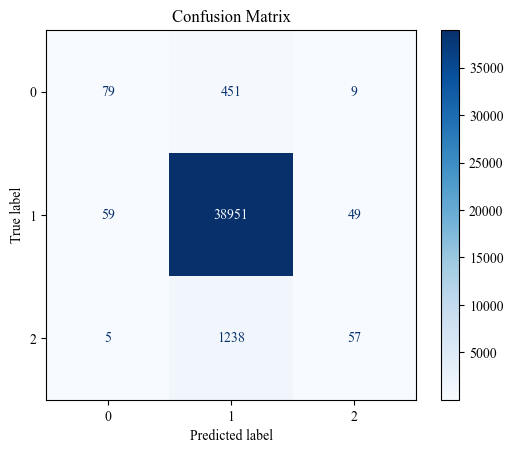

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion matrix 계산
cm = confusion_matrix(test_targets_np, ensemble_pred)

# Confusion matrix 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [23]:
accuracy = accuracy_score(test_targets_np, ensemble_pred)

In [24]:
# 데이터프레임을 CSV 파일로 저장 (선택사항)
df_results.to_csv('proposed_model_metrics_externaltest.csv')

In [25]:
labeled_df['pred']=ensemble_pred+1

In [26]:

filtered_df = labeled_df[labeled_df['Label'] == labeled_df['pred']].reset_index()

# 결과 확인
filtered_df = filtered_df.rename(columns={
    'height': 'Height',
    'weight': 'Weight',
    'step count': 'Step count',
    'burned calorie': 'Burned calorie',
    'eat calorie': 'Calorie intake',
    'sleep time': 'Sleep time'
})

In [27]:
filtered_df

,index,ID,Height,Weight,Step count,Burned calorie,Calorie intake,Sleep time,Start_Day,Label,pred
0,0,0,136.246429,28.478571,2051.107143,41.604375,2324.526395,462.0,0,2,2
1,1,0,136.295238,28.571429,2113.707143,41.604375,2329.058538,462.0,1,2,2
2,2,0,136.344048,28.664286,2205.121429,41.604375,2339.296038,462.0,2,2,2
3,3,0,136.392857,28.757143,2325.350000,41.604375,2343.763895,462.0,3,2,2
4,4,0,136.441667,28.850000,2474.392857,41.604375,2342.462110,462.0,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...
39082,40893,241,156.900000,47.500000,20000.000000,33.915000,1056.000000,459.6,164,2,2
39083,40894,241,156.900000,47.500000,20000.000000,33.915000,1056.000000,459.6,165,2,2
39084,40895,241,156.900000,47.500000,20000.000000,33.915000,1056.000000,459.6,166,2,2
39085,40896,241,156.900000,47.500000,20000.000000,33.915000,1056.000000,459.6,167,2,2


In [28]:
tabnet_model.feature_importances_

array([0.09749098, 0.21143988, 0.20750225, 0.19446085, 0.1206587 ,
       0.16844735])

### mask 계산

In [29]:
# TabNet 모델의 local importance 계산
masks, _ = tabnet_model.explain(test_np)

## 언더샘플링

In [30]:
import pandas as pd
from sklearn.utils import resample

# 각 라벨별로 100개씩 언더샘플링
result_df = pd.DataFrame()
for label in filtered_df['Label'].unique():
    # 라벨별 데이터 추출 및 샘플링
    samples = filtered_df[filtered_df['Label'] == label]
    if len(samples) > 50:
        samples = samples.sample(n=57, random_state=0) 
    
    # 결과에 추가
    result_df = pd.concat([result_df, samples])

# 인덱스 리셋
result_df = result_df.reset_index(drop=True)

# 확인
print(f"언더샘플링 결과 크기: {result_df.shape}")
print(result_df['Label'].value_counts())
result_df.to_excel('./data/7.undersampling_SHAP.xlsx',index=False)
result_df=pd.read_excel('./data/7.undersampling_SHAP.xlsx')

언더샘플링 결과 크기: (171, 11)
Label
2    57
3    57
1    57
Name: count, dtype: int64


In [31]:
top_5_ids = result_df.groupby('ID')['Start_Day'].count().sort_values(ascending=False).head(9)
print(top_5_ids)

ID
113    15
142    11
232    11
85     10
152     9
185     8
13      6
38      6
58      6
Name: Start_Day, dtype: int64


### 개별 개체 선택

In [32]:
# 증가
result_df[result_df['ID']==232]
gain_ID_df = result_df[result_df['ID'] == 232].sort_values(by='Start_Day', ascending=True)

In [33]:
gain_ID_df

,index,ID,Height,Weight,Step count,Burned calorie,Calorie intake,Sleep time,Start_Day,Label,pred
99,39337,232,172.714286,78.271429,1701.142857,41.604375,1092.696429,381.861751,129,3,3
113,39340,232,173.000000,79.166667,1723.654762,41.604375,1200.107143,368.341014,132,3,3
95,39341,232,173.107143,79.502381,1577.821429,41.604375,1198.821429,368.769585,133,3,3
78,39342,232,173.214286,79.838095,1489.035714,41.604375,1174.964286,373.483871,134,3,3
112,39343,232,173.321429,80.173810,1416.250000,41.604375,1136.250000,373.055300,135,3,3
87,39344,232,173.428571,80.509524,1475.464286,41.604375,1132.392857,378.769585,136,3,3
89,39345,232,173.535714,80.845238,1485.214286,41.604375,1106.785714,366.479263,137,3,3
70,39346,232,173.642857,81.180952,1445.500000,41.604375,1121.357143,385.764977,138,3,3
79,39347,232,173.750000,81.516667,1379.071429,41.604375,1153.285714,384.479263,139,3,3
108,39348,232,173.857143,81.852381,1400.357143,41.604375,1157.142857,378.479263,140,3,3


In [70]:
gain_index=39342
gain_start_day=134
shap_gain_index=78
gain_id=132

In [71]:
# 감소
result_df[result_df['ID']==113]
loss_ID_df = result_df[result_df['ID'] == 113].sort_values(by='Start_Day', ascending=True)

In [72]:
loss_ID

,index,ID,Height,Weight,Step count,Burned calorie,Calorie intake,Sleep time,Start_Day,Label,pred
69,19130,113,146.900000,38.142857,4774.714286,816.086155,3939.986401,468.894958,33,3,3
85,19131,113,146.900000,38.285714,4852.500000,1056.023298,3937.915651,469.894958,34,3,3
151,19165,113,147.500000,38.800000,6515.571429,1200.664000,1621.500000,487.714286,68,1,1
163,19166,113,147.657143,38.657143,6626.848776,1200.664000,1685.700000,489.071429,69,1,1
133,19168,113,147.971429,38.371429,5945.545204,1200.664000,1800.342857,485.214286,71,1,1
115,19169,113,148.128571,38.228571,5582.009490,1200.664000,1850.785714,483.285714,72,1,1
148,19170,113,148.285714,38.085714,5203.217823,1200.664000,1896.642857,481.357143,73,1,1
162,19171,113,148.442857,37.942857,4809.170204,1200.664000,1937.914286,479.428571,74,1,1
116,19172,113,148.600000,37.800000,4542.241633,1200.664000,1974.600000,477.500000,75,1,1
153,19173,113,148.757143,37.657143,4311.503538,1200.664000,2006.700000,475.571429,76,1,1


In [37]:
loss_index=19171
loss_start_day=74
shap_loss_index=162
loss_id=113

## TabNet 마스크

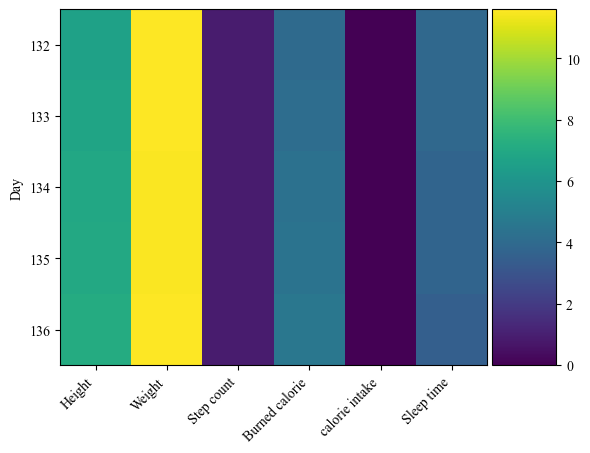

각 특성별 평균 중요도: [0.98788642 2.52583813 3.93222803 3.06344813 1.84051755 2.53544608]


In [38]:
# Import the required modules
# 증가
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 시각화를 위한 설정
fig, ax = plt.subplots(figsize=(6, 6))

labels = ['Height', 'Weight', 'Step count', 'Burned calorie', 'calorie intake', 'Sleep time']
im = ax.imshow(masks[gain_index-2:gain_index+3, :]) # 첫 8개 샘플만 표시

# 색상 막대 추가
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="15%", pad=0.05)
fig.colorbar(im, cax=cax)

# x축 레이블 설정
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')

# y축 인덱스 설정
y_indices = list(range(int(gain_start_day)-2, int(gain_start_day) + 3))

ax.set_yticks(range(len(y_indices)))
ax.yaxis.set_major_locator(plt.FixedLocator(range(len(y_indices))))
ax.set_yticklabels(y_indices)
ax.set_ylabel("Day")

plt.tight_layout()  # 레이아웃 조정
plt.show()

# 평균 중요도 출력
mean_importance = np.mean(masks, axis=0)
print("각 특성별 평균 중요도:", mean_importance)

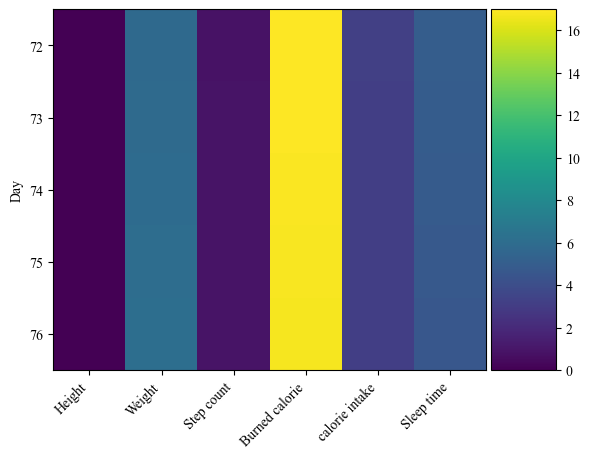

각 특성별 평균 중요도: [0.98788642 2.52583813 3.93222803 3.06344813 1.84051755 2.53544608]


In [39]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 시각화를 위한 설정
fig, ax = plt.subplots(figsize=(6, 6))

labels = ['Height', 'Weight', 'Step count', 'Burned calorie', 'calorie intake', 'Sleep time']
im = ax.imshow(masks[loss_index-2:loss_index+3, :]) # 첫 8개 샘플만 표시

# 색상 막대 추가
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="15%", pad=0.05)
fig.colorbar(im, cax=cax)

# x축 레이블 설정
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')

# y축 인덱스 설정
y_indices = list(range(int(loss_start_day)-2, int(loss_start_day) + 3))

ax.set_yticks(range(len(y_indices)))
ax.yaxis.set_major_locator(plt.FixedLocator(range(len(y_indices))))
ax.set_yticklabels(y_indices)
ax.set_ylabel("Day")

plt.tight_layout()  # 레이아웃 조정
plt.show()

# 평균 중요도 출력
mean_importance = np.mean(masks, axis=0)
print("각 특성별 평균 중요도:", mean_importance)

In [40]:
filtered_df['Label'].value_counts()

Label
2    38951
1       79
3       57
Name: count, dtype: int64

## SHAP

In [41]:
## shap을 위한 np
shap_test_np=result_df.iloc[:,2:8]
shap_test_targets_np=result_df.iloc[:,-2]-1

In [42]:
import pandas as pd
import pickle
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support as sk
from encoding_tabnet import train_tabnet_classifier,create_augmented_features
import os

# 현재 디렉토리 및 프로젝트 루트 디렉토리 경로 설정
# current_dir = os.path.dirname(os.path.abspath(__file__))
# path = os.path.dirname(current_dir)

def evaluate_generalization_shap(shap_test_np,shap_test_targets_np):
    """모델의 일반화 성능을 외부 데이터셋으로 평가하는 함수"""
    # 빈 리스트 생성하여 결과 저장
    results = []
    
    # nbsynthetic만 평가
    generation = 'nbsynthetic'
    
    # 외부 테스트 데이터 로드
    print(f"외부 테스트 데이터 크기2: {shap_test_np.shape}, 타겟 크기: {shap_test_targets_np.shape}")
    print(f"타겟 클래스 분포: {np.unique(shap_test_targets_np, return_counts=True)}")
    
    print(f"\n{generation} 모델로 외부 데이터 평가 중...")
    
    try:
        # TabNet 모델 로드
        tabnet_path = path + f'\\3_1.Training_XAI_Proposed\\model_hist\\{generation}_proposed_tabnetEmbedd2.pickle'
        with open(tabnet_path, 'rb') as f:
            tabnet_model = pickle.load(f)
        print(f"TabNet 모델 로드 성공: {tabnet_path}")
        
        # XGBoost 모델 로드
        xgb_path = path + f'\\3_1.Training_XAI_Proposed\\model_hist\\{generation}_proposed.pickle'
        with open(xgb_path, 'rb') as f:
            xgb_model = pickle.load(f)
        print(f"XGBoost 모델 로드 성공: {xgb_path}")
        
        # TabNet 임베딩 추출 및 특성 증강
        test_features = create_augmented_features(tabnet_model, test_np)
        print(f"TabNet 특성 증강 완료: {test_features.shape}")
        
        # TabNet으로 확률 예측
        tabnet_probs = tabnet_model.predict_proba(test_np)
        
        # XGBoost로 확률 예측
        xgb_probs = xgb_model.predict_proba(test_features)

        # 확률 합산 (앙상블)
        combined_probs = (tabnet_probs + xgb_probs)
        
        # 가장 높은 확률을 가진 클래스 선택
        ensemble_pred = np.argmax(combined_probs, axis=1)

        # 예측값 확인
        unique_values = np.array(list(set(ensemble_pred)))
        print(f"Unique values in prediction: {unique_values}")
        
        # 메트릭 계산
        accuracy = accuracy_score(test_targets_np, ensemble_pred)
        f1 = f1_score(test_targets_np, ensemble_pred, average='weighted')
        precision, recall = sk(test_targets_np, ensemble_pred, beta=1, average='weighted')[:2]
        
        results.append({
            'Model': f"{generation}-proposed_external",
            'Accuracy': round(accuracy, 5),
            'F1score': round(f1, 5), 
            'Precision': round(precision, 5),
            'Recall': round(recall, 5)
        })
        
    except Exception as e:
        print(f"{generation} 모델 평가 중 오류 발생: {str(e)}")
    
    # 결과를 데이터프레임으로 변환
    df_results = pd.DataFrame(results)
    print("\n외부 데이터셋에 대한 모델 성능 요약:")
    print(df_results)
    
    
    return df_results,ensemble_pred,tabnet_model


In [43]:
import shap
import numpy as np
import pickle

In [45]:

# def apply_ensemble_shap(test_data, tabnet_model, xgb_model, feature_names=None):
#     """
#     다중 분류 앙상블 모델에 SHAP 값을 적용하여 explainer와 shap_values만 반환
#     전체 test_data를 배경 데이터와 분석 데이터로 사용
#     """
#     if feature_names is None:
#         feature_names = [f'feature_{i}' for i in range(test_data.shape[1])]
    
#     # 앙상블 예측 함수 정의
#     def ensemble_predict(X):
#         if len(X.shape) == 1:
#             X = X.reshape(1, -1)
            
#         if X.shape[1] != test_data.shape[1]:
#             if X.shape[1] > test_data.shape[1]:
#                 X = X[:, :test_data.shape[1]]
            
#         tabnet_probs = tabnet_model.predict_proba(X)
#         augmented_X = create_augmented_features(tabnet_model, X)
#         xgb_probs = xgb_model.predict_proba(augmented_X)
#         combined_probs = tabnet_probs + xgb_probs
#         return combined_probs
    
#     # 전체 test_data를 배경 데이터로 사용
#     background_data = test_data
    
#     # KernelExplainer 초기화
#     ensemble_explainer = shap.KernelExplainer(
#         model=ensemble_predict,
#         data=background_data,
#         link="identity"
#     )
    
#     # 전체 test_data를 분석 데이터로 사용
#     analysis_data = test_data
    
#     # SHAP 값 계산
#     ensemble_shap_values = ensemble_explainer.shap_values(analysis_data)
    
#     # explainer와 shap_values만 반환
#     return ensemble_explainer, ensemble_shap_values

# def evaluate_generalization_with_shap(shap_test_np, shap_test_targets_np):
#     """모델 평가 및 SHAP 분석 수행"""
#     df_results, ensemble_pred, tabnet_model = evaluate_generalization_shap(shap_test_np, shap_test_targets_np)
    
#     generation = 'nbsynthetic'
#     xgb_path = path + f'\\3_1.Training_XAI_Proposed\\model_hist\\{generation}_proposed.pickle'
#     with open(xgb_path, 'rb') as f:
#         xgb_model = pickle.load(f)
    
#     # SHAP 분석 수행
#     explainer, shap_values = apply_ensemble_shap(
#         test_data=shap_test_np,
#         tabnet_model=tabnet_model,
#         xgb_model=xgb_model
#     )
    
#     return df_results, ensemble_pred, explainer, shap_values


# df_results, ensemble_pred, explainer, shap_values = evaluate_generalization_with_shap(shap_test_np,shap_test_targets_np)

In [56]:
import dill
# dill로 저장
# with open('./shap_explainer.dill', 'wb') as file:
#     dill.dump(explainer, file)

# # 나중에 불러오기
with open('shap_explainer.dill', 'rb') as file:
    explainer = dill.load(file)

In [57]:
import pickle
# with open('./shap_values.pickle','wb') as fw:
#     pickle.dump(shap_values, fw)

with open('./shap_values.pickle','rb') as f:
    shap_values = pickle.load(f)

In [58]:
result_df

,index,ID,Height,Weight,Step count,Burned calorie,Calorie intake,Sleep time,Start_Day,Label,pred
0,5515,32,147.600000,38.800000,8775.959432,41.604375,803.694444,522.000000,107,2,2
1,7355,43,160.600000,36.100000,184.000000,41.604375,603.000000,462.000000,88,2,2
2,34312,203,130.000000,30.000000,1866.000000,21.349000,2032.280357,462.000000,5,2,2
3,26105,154,152.000000,44.000000,2801.257353,26.063921,2613.198214,494.000000,79,2,2
4,36644,216,152.100000,35.000000,3226.337838,41.604375,5857.672885,612.774725,140,2,2
...,...,...,...,...,...,...,...,...,...,...,...
166,2253,13,141.600000,48.878571,7774.623262,41.604375,4340.915020,422.357143,56,1,1
167,31375,185,142.000000,29.142857,14535.229071,44.802643,2439.792857,640.800000,110,1,1
168,14909,88,156.500000,41.850000,9738.183324,41.604375,1990.135876,334.125000,37,1,1
169,9828,58,171.866667,44.125000,1159.839286,41.604375,2641.387767,462.000000,26,1,1


In [59]:
df_ID=result_df.iloc[:,2:8].columns
shap.force_plot(explainer.expected_value[0], shap_values[0], shap_test_np,feature_names = df_ID)


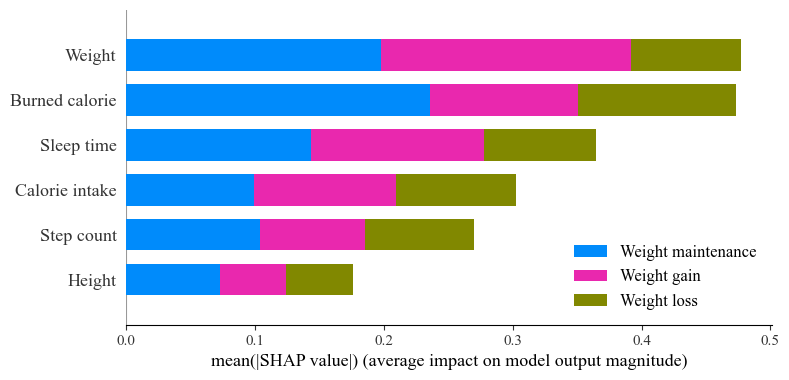

In [60]:
class_names=['Weight loss','Weight maintenance','Weight gain']
shap.summary_plot(shap_values, shap_test_np, plot_type="bar", class_names= class_names, feature_names = df_ID)

### 변수별 영향도 분산도

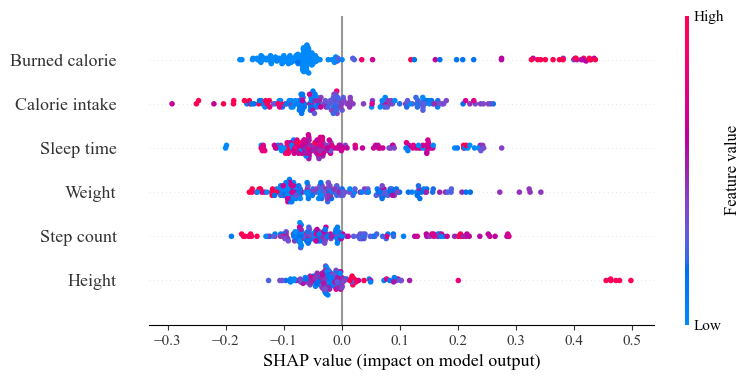

In [61]:
# 감소 
# 키가 크다-> 몸무게가 증가할 것 이다-> 감소를 예측할 확률에 대해서 줄어든다.
shap.summary_plot(shap_values[0], shap_test_np, feature_names = df_ID)

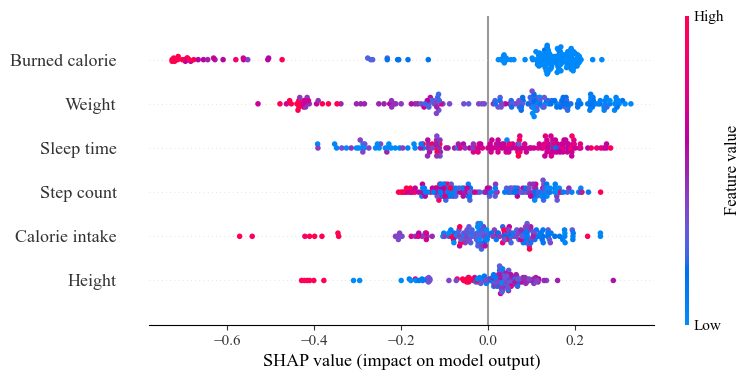

In [62]:
# 유지
shap.summary_plot(shap_values[1], shap_test_np, feature_names = df_ID)

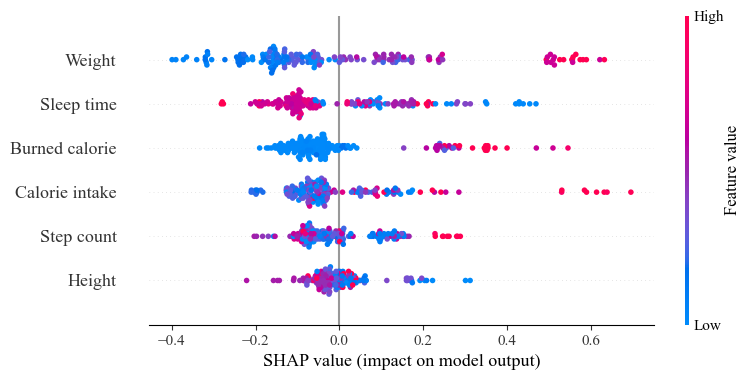

In [63]:
# 증가
shap.summary_plot(shap_values[2], shap_test_np, feature_names = df_ID)

### 의존성 플롯

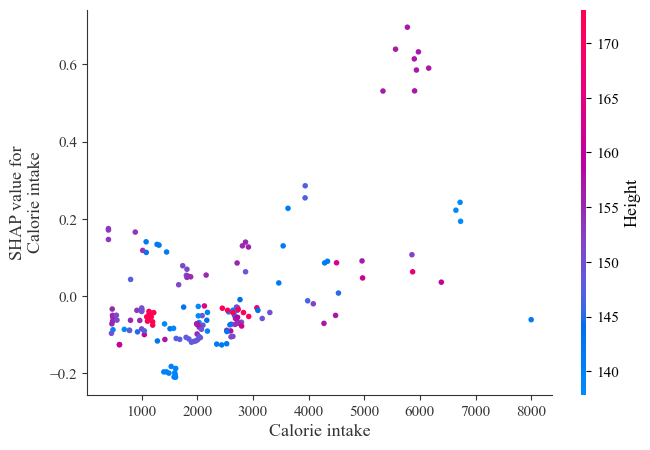

In [64]:
# 감소에 대해서 480분(8시간을)을 기점으로 점점 증가하는 
shap.dependence_plot(4, shap_values[2], shap_test_np, feature_names = df_ID,interaction_index=0)

### 개별 워터 플롯 해석

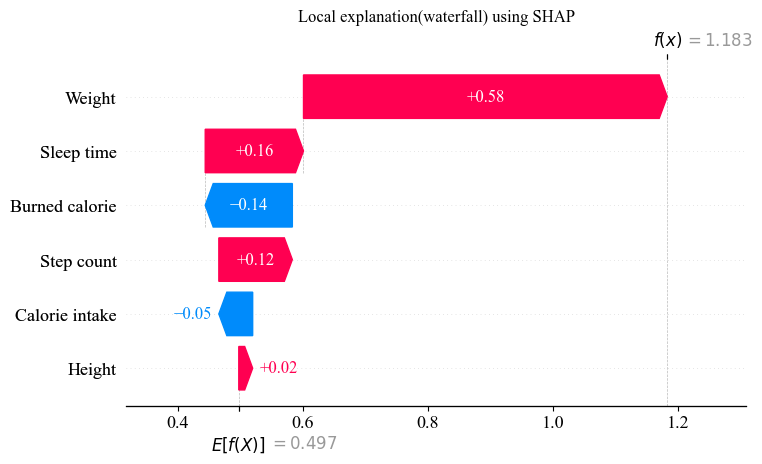

In [65]:
# 증가
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[2], shap_values[2][shap_gain_index],feature_names=df_ID,show=False)
plt.title("Local explanation(waterfall) using SHAP")
plt.show()

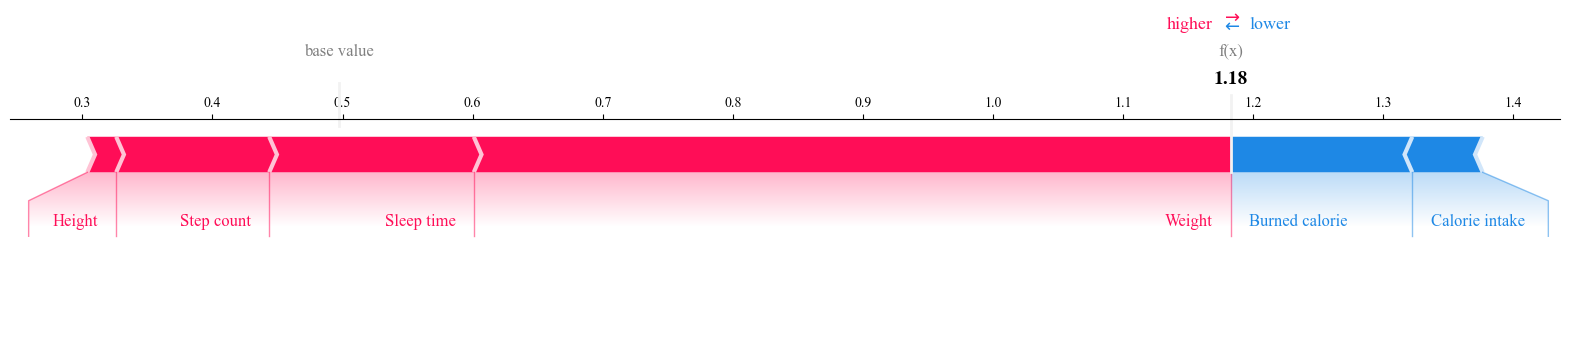

In [66]:
shap_force_plot =shap.force_plot(explainer.expected_value[2], shap_values[2][shap_gain_index],feature_names=df_ID,matplotlib=True,show=True)
plt.savefig('./shap_gain.png')

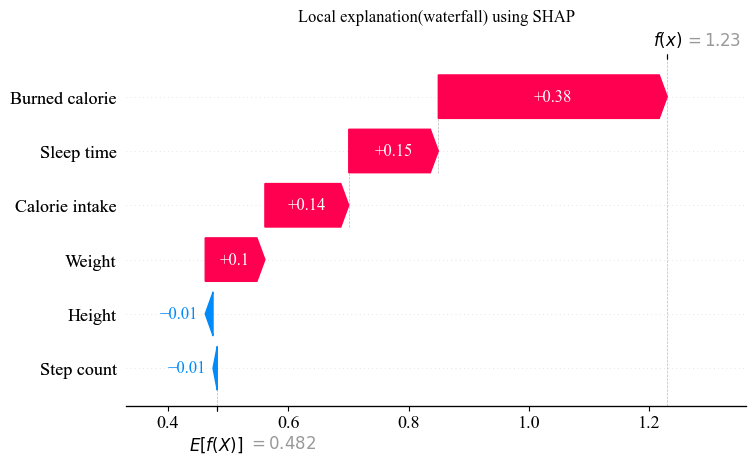

In [67]:
# 감소
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][shap_loss_index],feature_names=df_ID,show=False)
plt.title("Local explanation(waterfall) using SHAP")
plt.show()

### 증가인 사람 라이프로그 데이터 분석

In [73]:
labeled_df_id=labeled_df[labeled_df['ID']==gain_id]

In [74]:
labeled_df_id

,ID,height,weight,step count,burned calorie,eat calorie,sleep time,Start_Day,Label,pred
22308,132,140.0,33.0,1755.555060,32.071,1947.476786,521.408893,0,2,2
22309,132,140.0,33.0,1712.121528,32.071,1952.008929,529.803603,1,2,2
22310,132,140.0,33.0,1662.862103,32.071,1962.246429,538.991822,2,2,2
22311,132,140.0,33.0,1607.776786,32.071,1966.714286,548.973550,3,2,2
22312,132,140.0,33.0,1546.865575,32.071,1965.412500,559.748786,4,2,2
...,...,...,...,...,...,...,...,...,...,...
22472,132,145.4,38.5,1598.071429,32.071,744.000000,473.928571,164,2,2
22473,132,145.4,38.5,1422.392857,32.071,744.000000,470.964286,165,2,2
22474,132,145.4,38.5,1185.369048,32.071,744.000000,468.369048,166,2,2
22475,132,145.4,38.5,887.000000,32.071,744.000000,466.142857,167,2,2


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

v1 = 'burned calorie'
v2 = 'weight'

# v1_color='#7ABA78' # eat calorie color
# #v1_color='#A67B5B'  # step count color
# #v1_color='#EE4E4E'  # burned calorie color


v1_color = '#EE4E4E'  # burned calorie color
weight_color = '#4E4E4E'
start_day = 76
end_day = 83

# 시간에 따른 두 변수의 값
time = labeled_df_id['Start_Day'][:100]
variable1 = labeled_df_id[v1][:100]
variable2 = labeled_df_id[v2][:100]

# 스타일 설정
plt.style.use('seaborn-whitegrid')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

fig, ax1 = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('white')

ax1_min = min(variable1) - 5
ax1_max = max(variable1) 

# 주축(ax1)에 변수 x를 그림
line1, = ax1.plot(time, variable1, color=v1_color, linewidth=2, label=v1.capitalize(),
                  linestyle='-', marker='o', markersize=4, markevery=5)
ax1.set_xlabel('Day', fontsize=17, color='black')
ax1.set_ylabel(v1.capitalize(), fontsize=17, color='black')
ax1.tick_params(axis='y', colors='black', labelsize=17)
ax1.tick_params(axis='x', colors='black', labelsize=17)
ax1.set_ylim(ax1_min, ax1_max)

# 보조축(ax2) 생성
ax2 = ax1.twinx()
ax2.set_ylabel(v2.capitalize(), fontsize=17, color='black')
line2, = ax2.plot(time, variable2, color=weight_color, linewidth=2, label=v2.capitalize(),
                  linestyle='--', marker='s', markersize=4, markevery=5)
ax2.tick_params(axis='y', colors='black', labelsize=17)


# Highlighting a specific area
ax1.fill_between(time, ax1_max, where=(time >= start_day) & (time <= end_day), color='#C75B7A', alpha=0.5)

# 평균값 선 추가
mean_value = 80.45 
mean_line=ax1.axhline(y=mean_value, color='#EE4E4E', linestyle='--', linewidth=1.5, label='Mean Eat calorie')

# 범례 설정
lines = [line1, line2, mean_line]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(0,1), fontsize=13, frameon=False)

# 가로 그리드만 유지
ax1.grid(axis='y', linestyle='-', alpha=0.7)
ax1.grid(axis='x', linestyle='None')  # x축 그리드 제거
ax2.grid(False)

# 스파인 설정
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

# x축 레이블 간격 조정
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

v1 = 'eat calorie'
v2 = 'weight'

# v1_color='#7ABA78' # eat calorie color
# #v1_color='#A67B5B'  # step count color
# #v1_color='#EE4E4E'  # burned calorie color


v1_color = '#7ABA78'  # burned calorie color
weight_color = '#4E4E4E'
start_day = 76
end_day = 83

# 시간에 따른 두 변수의 값
time = labeled_df_id['Start_Day'][:100]
variable1 = labeled_df_id[v1][:100]
variable2 = labeled_df_id[v2][:100]

# 스타일 설정
plt.style.use('seaborn-whitegrid')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

fig, ax1 = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('white')

ax1_min = min(variable1) - 5
ax1_max = max(variable1) 

# 주축(ax1)에 변수 x를 그림
line1, = ax1.plot(time, variable1, color=v1_color, linewidth=2, label=v1.capitalize(),
                  linestyle='-', marker='o', markersize=4, markevery=5)
ax1.set_xlabel('Day', fontsize=17, color='black')
ax1.set_ylabel(v1.capitalize(), fontsize=17, color='black')
ax1.tick_params(axis='y', colors='black', labelsize=17)
ax1.tick_params(axis='x', colors='black', labelsize=17)
ax1.set_ylim(ax1_min, ax1_max)

# 보조축(ax2) 생성
ax2 = ax1.twinx()
ax2.set_ylabel(v2.capitalize(), fontsize=17, color='black')
line2, = ax2.plot(time, variable2, color=weight_color, linewidth=2, label=v2.capitalize(),
                  linestyle='--', marker='s', markersize=4, markevery=5)
ax2.tick_params(axis='y', colors='black', labelsize=17)


# Highlighting a specific area
ax1.fill_between(time, ax1_max, where=(time >= start_day) & (time <= end_day), color='#C75B7A', alpha=0.5)

# 평균값 선 추가
mean_value = 1549.07 
mean_line=ax1.axhline(y=mean_value, color='#7ABA78', linestyle='--', linewidth=1.5, label='Mean Eat calorie')

# 범례 설정
lines = [line1, line2, mean_line]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(0,1), fontsize=13, frameon=False)

# 가로 그리드만 유지
ax1.grid(axis='y', linestyle='-', alpha=0.7)
ax1.grid(axis='x', linestyle='None')  # x축 그리드 제거
ax2.grid(False)

# 스파인 설정
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

# x축 레이블 간격 조정
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

v1 = 'step count'
v2 = 'weight'

# v1_color='#7ABA78' # eat calorie color
# #v1_color='#A67B5B'  # step count color
# #v1_color='#EE4E4E'  # burned calorie color


v1_color = '#A67B5B'  # burned calorie color
weight_color = '#4E4E4E'
start_day = 76
end_day = 83

# 시간에 따른 두 변수의 값
time = labeled_df_id['Start_Day'][:100]
variable1 = labeled_df_id[v1][:100]
variable2 = labeled_df_id[v2][:100]

# 스타일 설정
plt.style.use('seaborn-whitegrid')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

fig, ax1 = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('white')

ax1_min = min(variable1) - 5
ax1_max = max(variable1) 

# 주축(ax1)에 변수 x를 그림
line1, = ax1.plot(time, variable1, color=v1_color, linewidth=2, label=v1.capitalize(),
                  linestyle='-', marker='o', markersize=4, markevery=5)
ax1.set_xlabel('Day', fontsize=17, color='black')
ax1.set_ylabel(v1.capitalize(), fontsize=17, color='black')
ax1.tick_params(axis='y', colors='black', labelsize=17)
ax1.tick_params(axis='x', colors='black', labelsize=17)
ax1.set_ylim(ax1_min, ax1_max)

# 보조축(ax2) 생성
ax2 = ax1.twinx()
ax2.set_ylabel(v2.capitalize(), fontsize=17, color='black')
line2, = ax2.plot(time, variable2, color=weight_color, linewidth=2, label=v2.capitalize(),
                  linestyle='--', marker='s', markersize=4, markevery=5)
ax2.tick_params(axis='y', colors='black', labelsize=17)


# Highlighting a specific area
ax1.fill_between(time, ax1_max, where=(time >= start_day) & (time <= end_day), color='#C75B7A', alpha=0.5)

# 평균값 선 추가
mean_value = 9748.90 
mean_line=ax1.axhline(y=mean_value, color='#A67B5B', linestyle='--', linewidth=1.5, label='Mean Eat calorie')

# 범례 설정
lines = [line1, line2, mean_line]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(0,1), fontsize=13, frameon=False)

# 가로 그리드만 유지
ax1.grid(axis='y', linestyle='-', alpha=0.7)
ax1.grid(axis='x', linestyle='None')  # x축 그리드 제거
ax2.grid(False)

# 스파인 설정
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

# x축 레이블 간격 조정
ax1.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.tight_layout()
plt.show()